<a href="https://colab.research.google.com/github/olwflynn/Learning/blob/master/Learning%20Physics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.0.0-5).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
libosmesa6-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
patchelf is already the newest version (0.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [31]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
!pip install free-mujoco-py mujoco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Now you need to restart the runtime as numpy is apparently automatically imported...**

In [33]:
import mujoco_py
import gym

In [34]:
import numpy as np

# def plt_update(ax, colors=['b']):
#     x = np.linspace(0,1,100)
#     if ax.lines:
#         for line in ax.lines:
#             line.set_xdata(x)
#             y = np.random.random(size=(100,1))
#             line.set_ydata(y)
#     else:
#         for color in colors:
#             y = np.random.random(size=(100,1))
#             ax.plot(x, y, color)
#     fig.canvas.draw()


def live_plot(data_dict, figsize=(7,5), title=''):
    # clear_output(wait=True)
    plt.figure(figsize=figsize)
    # for label,data in data_dict.items():
    obs = data_dict["obs"]
    preds = data_dict["preds"]
    print("obs: ", obs, "\n preds: ",preds)

    plt.plot(obs, label="obs")
    plt.plot(range(len(obs)-1, len(obs)+len(preds)-1), preds, label="preds")
    
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

Need to restart runtime if cant find 'mujuco'

In [35]:
env = gym.make("InvertedDoublePendulum-v4", new_step_api=True)
env.reset(seed=42)
env.step(env.action_space.sample())

(array([ 0.05483096, -0.0143515 ,  0.05935835,  0.99989701,  0.99823674,
        -0.09236559,  0.11084354, -0.36770122,  0.        ,  0.        ,
         0.        ]), 9.358185173540367, False, False, {})

In [36]:
# naive forecaster where we predict the angle at the next 3 steps is the same as the current angle

def naive_forecaster(X):
    # X is the all data known to the forecaster at the time. X is only the current and previous angles for now.
    
    current_angle = X[-1]
    angle_t_plus_1 = current_angle
    angle_t_plus_2 = current_angle
    angle_t_plus_3 = current_angle
    
    return np.array([angle_t_plus_1, angle_t_plus_2, angle_t_plus_3])


In [37]:
# get forecast error given a predicted trajectory and observations

def forecast_error(X_obs, preds):
    
    mse = sum(np.square(X_obs - preds)) / len(X_obs)
    
    return mse

epoch # 0
[ 0.00547175  0.08160824 -0.0707311   0.99666448  0.99749542 -1.88296822
  3.75316923 -4.88554496  0.          0.          0.        ] 9.223270457575698 False False {}
obs:  [0.08160823816042838] 
 preds:  [0.08160824 0.28160824 0.28160824 0.28160824]


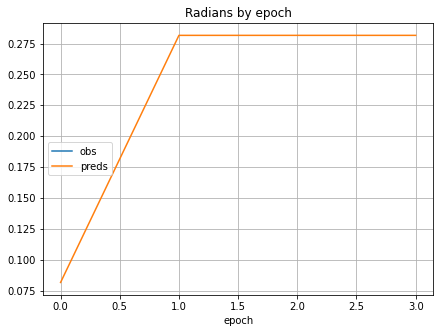

epoch # 1
[-0.12775816  0.3392609  -0.38791027  0.94069232  0.92169714 -3.40526583
  6.61324963 -7.58681343  0.          0.          0.        ] 8.968904100492548 False False {}
obs:  [0.08160823816042838, 0.33926090213211785] 
 preds:  [0.3392609 0.5392609 0.5392609 0.5392609]


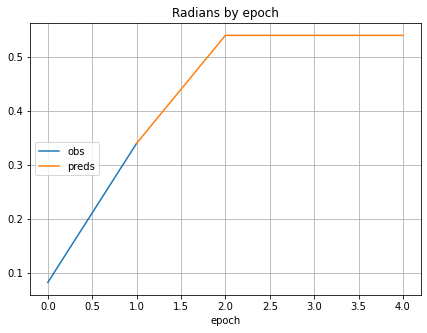

epoch # 2
[-0.32700755  0.65381572 -0.67792885  0.75665382  0.73512752 -4.50876861
  7.82526138 -5.57353154  0.          0.          0.        ] 8.887930433185543 False False {}
obs:  [0.08160823816042838, 0.33926090213211785, 0.6538157167062257] 
 preds:  [0.65381572 0.85381572 0.85381572 0.85381572]


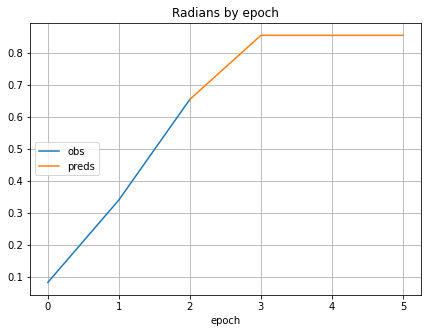

epoch # 3
[-0.5389814   0.88422061 -0.80921225  0.4670695   0.58751642 -3.97219455
  7.14329188 -2.4865295   0.          0.          0.        ] 8.650567516130351 True False {}
obs:  [0.08160823816042838, 0.33926090213211785, 0.6538157167062257, 0.884220606600462] 
 preds:  [0.88422061 1.08422061 1.08422061 1.08422061]


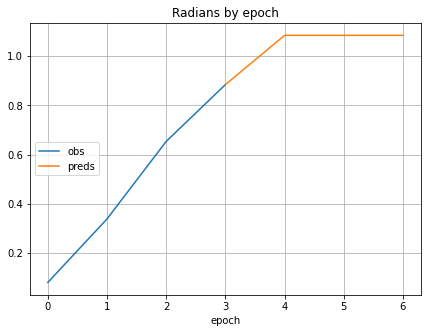

[0.08160823816042838, 0.33926090213211785, 0.6538157167062257, 0.884220606600462]
Prediction error in last 3 steps:  0.2600711101754775


In [38]:
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

# observation, info = env.reset(seed=42)
obs_history = []
# fig,ax = plt.subplots(1,1)
# ax.set_xlabel('t')
# ax.set_ylabel('obs_idx_1')
# ax.set_xlim(0,20)
# ax.set_ylim(-5,5)

for _ in range(10):
    print("epoch #", _)
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    print(observation, reward, terminated, truncated, info)
    obs_history.append(observation[1])
    # plt.plot(obs_history[0][0])
    # plt.show()
    preds = obs_history[-1]+[0, 0.2,0.2,0.2]
    # obs_concat_preds = obs_history
    # for pred in preds:
    #     obs_concat_preds.append(pred)
    live_plot({"obs": obs_history, "preds": preds}, title="Radians by epoch")
    time.sleep(1)
    if terminated or truncated:
        print(obs_history)
        print("Prediction error in last 3 steps: ", forecast_error(obs_history[-3:], preds[-3:]))
        break
        # obs_history = []
        # observation, info = env.reset()

env.close()

The episode ends when any of the following happens:

Truncation: The episode duration reaches 1000 timesteps.

Termination: Any of the state space values is no longer finite.

Termination: The absolutely value of the vertical angle between the pole and the cart is greater than 0.2 radian. i.e. 11.4592 degrees

1; vertical angle of the pole on the cart; -Inf; Inf; angle (rad)

*JTBD*

- Run thousands of episodes to generate training data with features (current and prev angles and other data) and labels (next few angles)
- Train forecast model to predict trajectory of angle
- Start episode with control over speed i.e. time lag between steps
- Predict expected time to end of episode at step t with measure of uncertainty
- Predict trajectory of angle in next few time steps at step t
- At end of episode output prediction errors at a few time steps


In [39]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import torch
X = torch.randn(1, 15)
print(X)

tensor([[ 0.8104,  0.1159,  0.3502,  0.3258, -0.3341,  1.6911, -0.5948, -0.0866,
          1.1552, -0.7714, -0.1760,  0.1096,  0.3431,  1.0017,  0.2276]])


In [41]:
y = torch.ones(1, 10)
print(y)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [42]:
# y = softmax(layer2(layer1(X)))

from torch import nn

class TestNetwork(nn.Module):
  def __init__(self):
    super(TestNetwork, self).__init__()
    self.seqlayers = nn.Sequential(
        nn.Linear(15, 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.ReLU(),
    )
    self.softmax = nn.Softmax(dim=1)

  def forward(self, X):
    hidden1 = self.seqlayers(X)
    output = self.softmax(hidden1)
    return output



In [43]:
model = TestNetwork()
print(model)

TestNetwork(
  (seqlayers): Sequential(
    (0): Linear(in_features=15, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
  )
  (softmax): Softmax(dim=1)
)


In [44]:
preds = model(X)
preds

tensor([[0.0892, 0.0954, 0.0894, 0.0892, 0.0892, 0.1094, 0.1250, 0.1345, 0.0892,
         0.0892]], grad_fn=<SoftmaxBackward0>)

In [45]:
preds.size()

torch.Size([1, 10])

In [46]:
loss_ = torch.nn.functional.binary_cross_entropy(preds, y)
loss_

tensor(2.3144, grad_fn=<BinaryCrossEntropyBackward0>)

In [47]:
# Backpropagation for one step
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

optimizer.zero_grad()
loss_.backward()
optimizer.step()

new_preds = model(X)
new_loss = torch.nn.functional.binary_cross_entropy(new_preds, y)

print(new_loss)

tensor(2.3134, grad_fn=<BinaryCrossEntropyBackward0>)


In [48]:
def create_rows_for_episode(ep_num):
  env.reset(seed=42)
  for _ in range(100):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    features = np.array(observation[:8]).reshape(1, 8)
    if _ == 0:
      rows_for_ep = features
    else:
      rows_for_ep = np.concatenate((rows_for_ep, features), axis=0)
    if terminated or truncated:
      labels = np.array(range(_, -1,-1)).reshape(_+1, 1)
      ep_num_arr = np.array([ep_num for i in range(len(labels))]).reshape(_+1, 1)
      assert len(labels) == len(rows_for_ep)
      rows_for_ep = np.concatenate((rows_for_ep, labels), axis=1)
      rows_for_ep = np.concatenate((rows_for_ep, ep_num_arr), axis=1)
      # print(len(rows_for_ep), type(rows_for_ep))
      return rows_for_ep
  
    

In [49]:
# create a dataset with positions of the pendulum as features and time to terminate as label

import pandas as pd

columns = []
for i in range(8):
  columns.append(f'feature_{i}')
columns.append('time_to_terminate')
columns.append('ep_num')

#create array
num_episodes = 10000
for j in range(num_episodes):
  episode_rows = create_rows_for_episode(j)
  if j == 0:
    arr = episode_rows
  else:
    arr = np.concatenate([arr, episode_rows], axis=0)
env.close()

df = pd.DataFrame(arr, columns=columns)
print(df.head())
print(df.describe())
print(df.info())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.029096   0.038629  -0.007881   0.999254   0.999969  -1.123820   
1   0.019096   0.058999  -0.048719   0.998258   0.998813   0.720988   
2   0.094824  -0.091011   0.120087   0.995850   0.992763   2.309668   
3   0.226911  -0.347001   0.405409   0.937865   0.914135   2.952891   
4   0.404327  -0.634410   0.655356   0.772997   0.755320   4.091090   

   feature_6  feature_7  time_to_terminate  ep_num  
0   2.251015  -3.105813                5.0     0.0  
1  -1.410529   1.409108                4.0     0.0  
2  -4.618962   5.377011                3.0     0.0  
3  -5.825706   6.205230                2.0     0.0  
4  -7.269696   5.014309                1.0     0.0  
          feature_0     feature_1     feature_2     feature_3     feature_4  \
count  63568.000000  63568.000000  63568.000000  63568.000000  63568.000000   
mean       0.054536     -0.034245      0.064375      0.886206      0.817727   
std        0.22542

In [50]:
# terminating conditions of the episodes

df_terminated = df[df['time_to_terminate']==0]
print(df_terminated.head())
print(df_terminated.describe())
print(df_terminated.info())

    feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
5    0.631108  -0.872746   0.759749   0.488174   0.650217   4.935035   
14  -0.118658   0.605889  -0.940565   0.795549   0.339613  -1.717182   
26   0.418552  -0.833164   0.926927   0.553025   0.375241   0.105695   
32  -0.247355   0.702812  -0.898282   0.711376   0.439419  -1.180744   
38  -0.306553   0.734416  -0.868518   0.678699   0.495657  -2.571194   

    feature_6  feature_7  time_to_terminate  ep_num  
5   -7.446171   0.443128                0.0     0.0  
14   4.934877  -6.554595                0.0     1.0  
26  -3.705184   6.106715                0.0     2.0  
32   4.153306  -5.818495                0.0     3.0  
38   5.533606  -4.726858                0.0     4.0  
          feature_0     feature_1     feature_2     feature_3     feature_4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.062741     -0.067022      0.084103      0.625960      0.462881   
std   

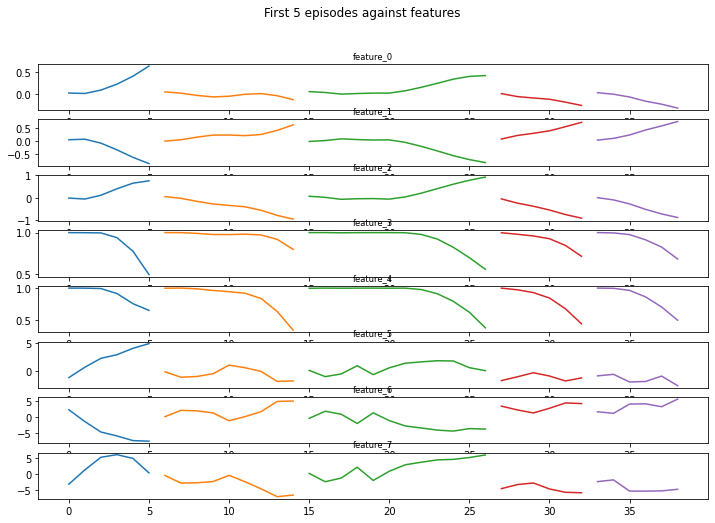

In [51]:
# plot a five of the episodes against various features

ep_split_df = [df[df['ep_num']==i] for i in range(5)]
num_features = 8
fig, axs = plt.subplots(num_features, figsize=(12, 8))
plt.suptitle('First 5 episodes against features')
for i in range(num_features):
  for el in ep_split_df:
    ep = el['ep_num'].values[0]
    axs[i].plot(el[f'feature_{i}'], label=f'episode_{int(ep)}')
    axs[i].set_title(f'feature_{i}', fontsize='small')
# plt.legend(loc='right')
plt.show()

In [52]:
from random import triangular
# prepare dataset for train, validate, test
# use final 20% episodes for testing

test_size = 0.2*num_episodes
valid_size = 0.1*num_episodes
train_size = num_episodes - (test_size+valid_size)

test_df = df[df['ep_num']<=test_size]
valid_df = df[(df['ep_num']>test_size)&(df['ep_num']<=(valid_size+test_size))]
train_df = df[(df['ep_num']>(valid_size+test_size))]

features = []
for i in range(8):
  features.append(f'feature_{i}')

test_labels = test_df['time_to_terminate']
test_features = test_df[features]

valid_labels = valid_df['time_to_terminate']
valid_features = valid_df[features]

train_labels = train_df['time_to_terminate']
train_features = train_df[features]

print('Test dataset shapes:', test_labels.shape, test_features.shape)
print('Validation dataset shapes:', valid_labels.shape, valid_features.shape)
print('Train dataset shapes:', train_labels.shape, train_features.shape)

Test dataset shapes: (12795,) (12795, 8)
Validation dataset shapes: (6380,) (6380, 8)
Train dataset shapes: (44393,) (44393, 8)


In [53]:
# linear regression model to predict time_to_terminate using features as baseline
# this model does not take into account the time series i.e. it assumes that t, t+1 are independent

from sklearn.linear_model import LinearRegression

regr = LinearRegression()

regr.fit(train_features, train_labels)

preds = regr.predict(test_features)

print('MSE: \n', forecast_error(test_labels, preds))
print('Score: \n', regr.score(test_features, test_labels))

MSE: 
 2.006448636554784
Score: 
 0.6220982104247623


In [54]:
print(regr.coef_)
print(regr.intercept_)

[ 7.34238737e+00  6.51136571e+00  2.55066633e+00  5.10208973e+00
  5.21089377e+00 -1.63005264e-01 -6.05432575e-02  1.66079548e-03]
-6.1799543991738615


Results:

> n=100, mse=2.07, model=lin reg
coef= [ 1.33349380e+00 -6.43072005e-01 -1.25702564e+00  6.48821446e+00
  5.30884445e+00 -1.92036934e-01 -8.90950510e-02 -3.15731262e-03]
intercept= -7.1225544550046775



> n=10000, mse=2.07, model=lin reg
coef=[ 8.05432692  6.7247005   2.55556171  4.98903376  5.38681353 -0.09618963
  0.021658    0.03276889]
intercept=-6.228216297398191





In [55]:
# log linear so only positve? 
# look at gamma regression to use linear regression and only predict positive values

from sklearn.linear_model import PoissonRegressor

pois_regr = PoissonRegressor()

pois_regr.fit(train_features, train_labels)

pois_preds = pois_regr.predict(test_features)
print('Poisson model')
print('MSE: \n', forecast_error(test_labels, pois_preds))
print('Score: \n', pois_regr.score(test_features, test_labels))

Poisson model
MSE: 
 4.424204694102423
Score: 
 0.15328830788592485


In [56]:
from sklearn.linear_model import TweedieRegressor

tweed_regr = TweedieRegressor(power=1.5)

tweed_regr.fit(train_features, train_labels)

tweed_preds = tweed_regr.predict(test_features)
print('Tweedie w/ power=1.5')
print('MSE: \n', forecast_error(test_labels, tweed_preds))
print('Score: \n', tweed_regr.score(test_features, test_labels))

Tweedie w/ power=1.5
MSE: 
 4.7399515965350005
Score: 
 0.07121026784776197


In [57]:
# take linear model but set preds less than zero to 0.
preds_positive = preds.copy()
preds_positive[preds_positive < 0] =  0

print('Positive only predictions linear model')
print('MSE: \n', forecast_error(test_labels, preds_positive))


Positive only predictions linear model
MSE: 
 1.8949439384928675


In [58]:
# wants to learn the x^2 features so linear is a bad model e.g. direction (+/-) does not matter for falling for pendulum
# implement NN to add non-linearity - use softplus for output

class DenseNet(nn.Module):
  def __init__(self):
    super(DenseNet, self).__init__()
    self.layer1 = nn.Linear(8,20)
    self.layer2 = nn.Linear(20,1)
    self.softplus = nn.Softplus()
  
  def forward(self, X):
    hidden1 = self.layer1(X)
    hidden2 = self.layer2(hidden1)

    output = self.softplus(hidden2)
    return output

In [60]:
dense_model = DenseNet()
print(dense_model)

DenseNet(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=1, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)


In [68]:
# Test fwd pass of NN
X_fwd_pass = torch.ones(1, 8, dtype=torch.float32, device='cpu')
dense_model(X_fwd_pass)

tensor([[0.7258]], grad_fn=<SoftplusBackward0>)

In [75]:
# preprocess data into pytorch tensors

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device: \n', device)

train_labels_tensor = torch.tensor(train_labels.values, dtype=dtype, device=device).view(len(train_labels), -1)
train_features_tensor = torch.tensor(train_features.values, dtype=dtype, device=device, requires_grad=True)

valid_labels_tensor = torch.tensor(valid_labels.values, dtype=dtype, device=device).view(len(valid_labels), -1)
valid_features_tensor = torch.tensor(valid_features.values, dtype=dtype, device=device)

test_labels_tensor = torch.tensor(test_labels.values, dtype=dtype, device=device).view(len(test_labels), -1)
test_features_tensor = torch.tensor(test_features.values, dtype=dtype, device=device)

print('Test tensor shapes:', test_labels_tensor.shape, test_features_tensor.shape)
print('Validation tensor shapes:', valid_labels_tensor.shape, valid_features_tensor.shape)
print('Train tensor shapes:', train_labels_tensor.shape, train_features_tensor.shape)

Using device: 
 cuda
Test tensor shapes: torch.Size([12795, 1]) torch.Size([12795, 8])
Validation tensor shapes: torch.Size([6380, 1]) torch.Size([6380, 8])
Train tensor shapes: torch.Size([44393, 1]) torch.Size([44393, 8])


In [78]:
from sklearn.metrics import log_loss
# Training loop

def train(y_train, X_train, y_valid, X_valid, y_test, X_test, model_, \
          epochs=10000, learning_rate=0.1):
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model_.parameters(), lr=learning_rate)

  for epoch in range(epochs):
    optimizer.zero_grad()

    train_preds = model_(X_train)
    train_loss = torch.sqrt(criterion(train_preds, y_train))
    if epoch % 500 == 0:
      valid_preds = model_(X_valid)
      valid_loss = torch.sqrt(criterion(valid_preds, y_valid))
      print(f'epoch #{epoch} \n training loss: \n', train_loss.item(), \
            '\n validation loss: \n', valid_loss.item(), '\n')
    train_loss.backward()
    optimizer.step()

  test_preds = model_(X_test)
  test_loss = torch.sqrt(criterion(test_preds, y_test))

  print('Final metrics: \n training loss: ', train_loss.item(), \
        '\n validation loss: ', valid_loss.item(),'\n test loss: ', \
        test_loss.item())


In [79]:
# model to gpu and train
dense_model.to(device)

train(train_labels_tensor, train_features_tensor, valid_labels_tensor, valid_features_tensor, \
      test_labels_tensor, test_features_tensor, dense_model, epochs=10000)

epoch #0 
 training loss: 
 1.5563859939575195 
 validation loss: 
 1.6023122072219849 

epoch #500 
 training loss: 
 1.493034839630127 
 validation loss: 
 1.518715500831604 

epoch #1000 
 training loss: 
 1.555769681930542 
 validation loss: 
 1.5603400468826294 

epoch #1500 
 training loss: 
 1.4963276386260986 
 validation loss: 
 1.510853886604309 

epoch #2000 
 training loss: 
 1.4909358024597168 
 validation loss: 
 1.5129611492156982 

epoch #2500 
 training loss: 
 1.4758461713790894 
 validation loss: 
 1.4960761070251465 

epoch #3000 
 training loss: 
 1.4486546516418457 
 validation loss: 
 1.4676833152770996 

epoch #3500 
 training loss: 
 1.4228014945983887 
 validation loss: 
 1.4407752752304077 

epoch #4000 
 training loss: 
 1.4065182209014893 
 validation loss: 
 1.4212504625320435 

epoch #4500 
 training loss: 
 1.4031617641448975 
 validation loss: 
 1.4143996238708496 

epoch #5000 
 training loss: 
 1.3915735483169556 
 validation loss: 
 1.402589797973632

In [80]:
# next add reLU for additional non-linearity

class DenseNetRelu(nn.Module):
  def __init__(self):
    super(DenseNetRelu, self).__init__()
    self.layer1 = nn.Linear(8,20)
    self.relu1 = nn.ReLU()
    self.layer2 = nn.Linear(20,1)
    self.relu2 = nn.ReLU()
    self.softplus = nn.Softplus()
  
  def forward(self, X):
    hidden1 = self.relu1(self.layer1(X))
    hidden2 = self.relu2(self.layer2(hidden1))

    output = self.softplus(hidden2)
    return output

In [81]:
dense_plus_relu_model = DenseNetRelu()
print(dense_plus_relu_model)

DenseNetRelu(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=20, out_features=1, bias=True)
  (relu2): ReLU()
  (softplus): Softplus(beta=1, threshold=20)
)


In [83]:
dense_plus_relu_model.to(device)

train(train_labels_tensor, train_features_tensor, valid_labels_tensor, valid_features_tensor, \
      test_labels_tensor, test_features_tensor, dense_plus_relu_model, epochs=10000)

epoch #0 
 training loss: 
 3.2289772033691406 
 validation loss: 
 3.25728178024292 

epoch #500 
 training loss: 
 1.1824253797531128 
 validation loss: 
 1.212167501449585 

epoch #1000 
 training loss: 
 1.1570030450820923 
 validation loss: 
 1.1943438053131104 

epoch #1500 
 training loss: 
 1.1065583229064941 
 validation loss: 
 1.141268253326416 

epoch #2000 
 training loss: 
 1.1210112571716309 
 validation loss: 
 1.1496469974517822 

epoch #2500 
 training loss: 
 1.1069321632385254 
 validation loss: 
 1.141946792602539 

epoch #3000 
 training loss: 
 1.1219919919967651 
 validation loss: 
 1.1525228023529053 

epoch #3500 
 training loss: 
 1.0893374681472778 
 validation loss: 
 1.1197834014892578 

epoch #4000 
 training loss: 
 1.0881584882736206 
 validation loss: 
 1.1128816604614258 

epoch #4500 
 training loss: 
 1.102583408355713 
 validation loss: 
 1.125156044960022 

epoch #5000 
 training loss: 
 1.088857889175415 
 validation loss: 
 1.1127490997314453 



In [ ]:
class LSTMnet(nn.Module):
  def __init__(self):
    super(LSTMnet, self).__init__()
    self.lstm = nn.LSTM(8, 16)
    self.linear = nn.Linear(16, 1)
    self.softplus = nn.Softplus()
  
  def forward(self, ep_features):
    # embeds.view(len(sentence), 1, -1)) --> ??
    lstm_out, _ = self.lstm(ep_features.view(len(ep_features),1,-1))
    linear_out = self.linear(lstm_out.view(len(ep_features), -1))
    output = self.softplus(linear_out)

    return output

In [ ]:
test_episode = df[df['ep_num']==0]
test_episode_feats = torch.tensor(test_episode[features].values, dtype=dtype, device=device)
test_episode_labs = torch.tensor(test_episode['time_to_terminate'].values, dtype=dtype, device=device)

lstm_model = LSTMnet()
lstm_model(test_episode_feats)

In [ ]:
# prepare data for lstm i.e. [(ep1_features, ep1_labels), (ep2_features, ep2_labels), ...] in tensors

eps = []

for ep_num in range(num_episodes):
  episode = df[df['ep_num']==ep_num]
  episode_feats = torch.tensor(episode[features].values, dtype=dtype, device=device, requires_grad=True)
  episode_labs = torch.tensor(episode['time_to_terminate'].values, dtype=dtype, device=device).view(len(episode),-1)
  eps.append((episode_feats, episode_labs))

assert len(eps) == num_episodes


In [ ]:
# try lstm to enable dependency between t, t+1 but only within the same episode
# train on gpu


def lstm_train(episodes, model_, epochs=10000, learning_rate=0.1):
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model_.parameters(), lr=learning_rate)
  for epoch in range(epochs):
    for ep_features, ep_labels in episodes:
      optimizer.zero_grad()

      ep_preds = model_(ep_features)
      ep_loss = torch.sqrt(criterion(ep_preds, ep_labels))
      ep_loss.backward()
      optimizer.step()
    if epoch % 1 == 0:
      print(f'epoch #{epoch} loss: \n', ep_loss.item())
    

In [ ]:
lstm_train(eps, lstm_model, epochs=1000)

In [61]:
sample = df.sample()
sample_feat = sample[features]
sample_lab = sample['time_to_terminate']
print('Linear model: ',regr.predict(sample_feat)[0])
print('Poisson model: ', pois_regr.predict(sample_feat)[0])
print('DenseNet model: ', dense_model(torch.tensor(sample_feat.values, dtype=dtype, device=device)).item())
print('DenseNetRelu model: ', dense_plus_relu_model(torch.tensor(sample_feat.values, dtype=dtype, device=device)).item())
print('LSTM model: ', lstm_model(torch.tensor(sample_feat.values, dtype=dtype, device=device)).item())
print('Actual:  ', sample_lab.values[0])

Linear model:  4.496713472349312
Poisson model:  3.231310723847726


NameError: ignored

In [ ]:
# batch processing and put on gpu

In [ ]:
# test on the test dataset

# make sure only training on the the train dataset- currently all df 